In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 서비스 계정 키 경로 설정
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/home/eunyu/sprintda05-eunyu-a9946f7dea9c.json"

# GCS의 Parquet 파일 경로
gcs_path = 'gs://final_project_enuyu/data/final_project/votes/event_receipts.parquet'

# 데이터 불러오기
event_receipts_df = pd.read_parquet(gcs_path, engine='pyarrow')
event_receipts_df

,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500
...,...,...,...,...,...
304,317,2023-11-14 11:17:29,3,918053,500
305,318,2023-11-15 05:09:02,3,932419,500
306,319,2023-11-17 06:17:25,3,1188104,500
307,320,2023-11-17 06:17:59,3,1296978,500


In [3]:
event_receipts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          309 non-null    int64         
 1   created_at  309 non-null    datetime64[ns]
 2   event_id    309 non-null    int64         
 3   user_id     309 non-null    int64         
 4   plus_point  309 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 12.2 KB


In [4]:
event_receipts_df.isnull().sum()

id            0
created_at    0
event_id      0
user_id       0
plus_point    0
dtype: int64

In [5]:
event_receipts_df.describe(include='all')

,id,created_at,event_id,user_id,plus_point
count,309.000000,309,309.000000,3.090000e+02,309.000000
mean,160.964401,2023-07-24 01:53:59.954692608,1.249191,1.179715e+06,559.870550
min,2.000000,2023-06-22 09:25:16,1.000000,8.378360e+05,500.000000
25%,82.000000,2023-07-10 16:58:20,1.000000,9.998160e+05,500.000000
50%,161.000000,2023-07-20 12:24:28,1.000000,1.139491e+06,500.000000
75%,239.000000,2023-07-29 09:38:22,1.000000,1.325911e+06,500.000000
max,321.000000,2023-11-21 12:03:02,3.000000,1.579064e+06,1000.000000
std,92.065029,NaN,0.563536,2.171981e+05,162.592579


#### event_id별 plus_point 평균 비교

In [6]:
# event_id별 plus_point의 평균, 중앙값, 최대값 비교
event_summary = event_receipts_df.groupby("event_id")["plus_point"].agg(["count", "mean", "median", "max", "min"]).reset_index()
print(event_summary)

   event_id  count    mean  median   max   min
0         1    252   500.0   500.0   500   500
1         2     37  1000.0  1000.0  1000  1000
2         3     20   500.0   500.0   500   500


- event_id = 1: 가장 많은 참여가 있었고, 500포인트가 고정 지급됨.
- event_id = 2: 소수만 참여했지만 1000포인트 고정 지급 → 고보상 이벤트
- event_id = 3: 참여 수는 적고, 다시 500포인트 지급

#### created_at 기준 이벤트 수 추이 

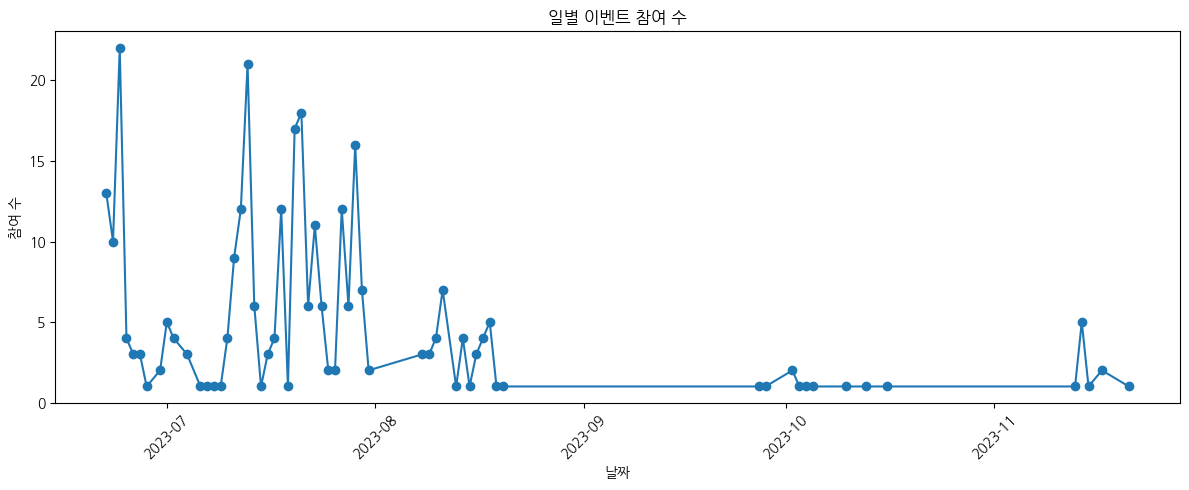

In [7]:

# 날짜만 추출
event_receipts_df["created_date"] = pd.to_datetime(event_receipts_df["created_at"]).dt.date

# 일별 이벤트 수 시각화
event_counts = event_receipts_df["created_date"].value_counts().sort_index()
plt.figure(figsize=(12, 5))
plt.plot(event_counts.index, event_counts.values, marker='o')
plt.title("일별 이벤트 참여 수")
plt.xlabel("날짜")
plt.ylabel("참여 수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 유저별 참여 횟수 및 누적 지급 포인트 분석

In [8]:
# 유저별 참여 횟수 및 누적 포인트
user_summary = event_receipts_df.groupby("user_id")["plus_point"].agg(["count", "sum"]).reset_index()
user_summary.columns = ["user_id", "participation_count", "total_plus_point"]
user_summary.sort_values(by="total_plus_point", ascending=False).head()

,user_id,participation_count,total_plus_point
0,837836,1,1000
282,1541150,1,1000
138,1115176,1,1000
133,1107696,1,1000
270,1512731,1,1000


#### plus_point 분포

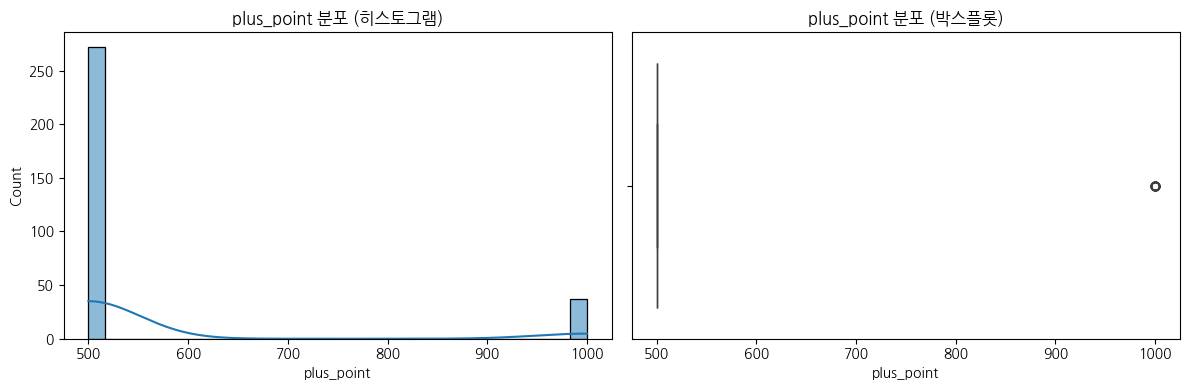

In [9]:

plt.figure(figsize=(12, 4))

# 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(event_receipts_df["plus_point"], bins=30, kde=True)
plt.title("plus_point 분포 (히스토그램)")

# 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=event_receipts_df["plus_point"])
plt.title("plus_point 분포 (박스플롯)")

plt.tight_layout()
plt.show()


#### event_id별 참여 유저 수 비교

In [10]:
# event_id별 고유 유저 수
event_user_counts = event_receipts_df.groupby("event_id")["user_id"].nunique().reset_index()
event_user_counts.columns = ["event_id", "unique_user_count"]
print(event_user_counts)

   event_id  unique_user_count
0         1                251
1         2                 37
2         3                 20
